# Segmenting Customers into Groups

## Importing libraries

In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Reading the dataset

Source : https://archive.ics.uci.edu/ml/datasets/online+retail
  
Input variables :

* InvoiceNo
* StockCode
* Description
* Quantity
* InvoiceDate
* UnitPrice
* CustomerID
* Country

---


In [18]:
df = pd.read_excel('https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [19]:
df.shape

(541909, 8)

### Getting rid of missing values

In [20]:
pd.isna(df).any()

InvoiceNo      False
StockCode      False
Description     True
Quantity       False
InvoiceDate    False
UnitPrice      False
CustomerID      True
Country        False
dtype: bool

In [21]:
df = df[df['CustomerID'].notna()]
df = df[df['Description'].notna()]

In [22]:
df.shape

(406829, 8)

## Create RFM Table (Recency-Frequency-MonetaryValue)

### Add Total Column : MonetaryValue

In [23]:
df['Total'] = df['Quantity'] * df['UnitPrice']

### Arrange Invoice Date : Recency

In [24]:
from datetime import datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')
df['InvoiceDate'] = df['InvoiceDate'].dt.date

In [25]:
import datetime
df_date = max(df.InvoiceDate) + datetime.timedelta(days=1)

### Aggregate customer data and count : Frequency

In [26]:
customers = df.groupby(['CustomerID']).agg({
        'InvoiceDate': lambda x: (df_date - x.max()).days,
        'InvoiceNo': 'count',
        'Total': 'sum'
    })

### Show table

In [27]:
# Rename columns
customers.rename(columns = {'InvoiceDate': 'Recency',
                            'InvoiceNo': 'Frequency',
                            'Total': 'MonetaryValue'}, inplace=True)

In [28]:
customers.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346.0,326,2,0.00
12347.0,3,182,4310.00
12348.0,76,31,1797.24
12349.0,19,73,1757.55
12350.0,311,17,334.40


##Manage the Skewness

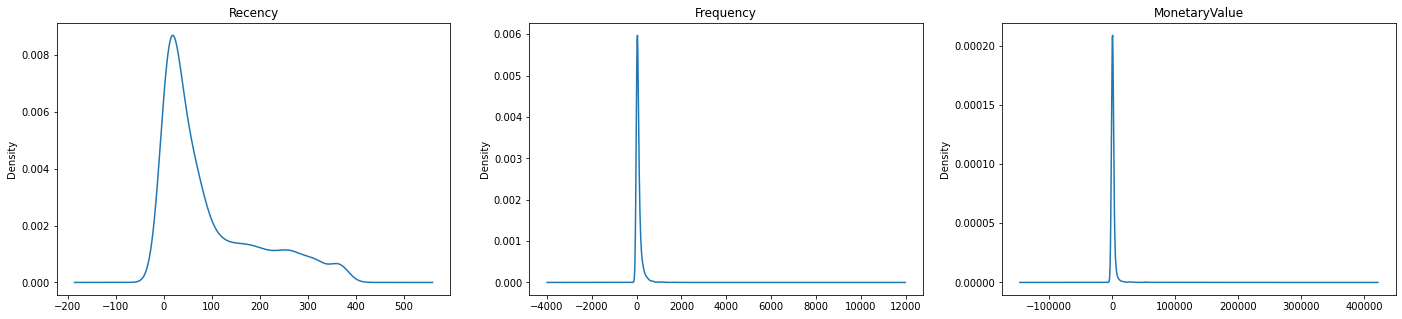

In [29]:
plt.figure(figsize = (24, 5))

plt.subplot(131)
plt.title("Recency")
customers['Recency'].plot(kind = 'density')

plt.subplot(132)
plt.title("Frequency")
customers['Frequency'].plot(kind = 'density')

plt.subplot(133)
plt.title("MonetaryValue")
customers['MonetaryValue'].plot(kind = 'density')

### Using box-cox

In [30]:
from scipy import stats
customers_fix = pd.DataFrame()
customers_fix["Recency"] = stats.boxcox(customers['Recency'])[0]
customers_fix["Frequency"] = stats.boxcox(customers['Frequency'])[0]
customers_fix["MonetaryValue"] = pd.Series(np.cbrt(customers['MonetaryValue'])).values
customers_fix.tail()

,Recency,Frequency,MonetaryValue
4367,8.932980,2.460908,5.652483
4368,7.949051,2.058202,4.323541
4369,2.449000,2.762414,5.610440
4370,1.544575,8.057611,12.795376
4371,5.087438,4.808490,12.247810


## Normalizing the data

In [16]:
from sklearn.preprocessing import StandardScaler
stdscaler = StandardScaler()

In [31]:
stdscaler.fit(customers_fix)
customers_normalized = stdscaler.transform(customers_fix)
# Assert that it has mean 0 and variance 1
print(customers_normalized.mean(axis = 0).round(2)) 
print(customers_normalized.std(axis = 0).round(2)) 

[-0.  0. -0.]
[1. 1. 1.]


## Clustering the data

### Using K-means Algorithm

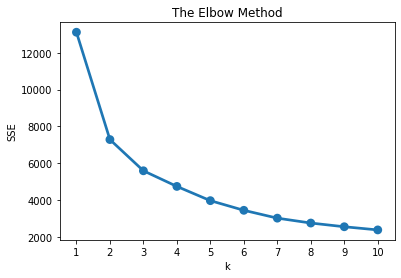

In [34]:
from sklearn.cluster import KMeans
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customers_normalized)
    sse[k] = kmeans.inertia_ # SSE to closest cluster centroid
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

We will go with K=3 because it expresses a linear trend with K=4.

In [35]:
model = KMeans(n_clusters=3, random_state=42)
model.fit(customers_normalized)
model.labels_.shape

(4372,)

In [36]:
customers["Cluster"] = model.labels_
customers.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'MonetaryValue':['mean', 'count']}).round(2)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0        185.28     19.22        352.11  1659
1         42.91     67.52       1008.26  1934
2         18.48    313.69       7401.71   779

### Snake Plots

In [39]:
df_normalized = pd.DataFrame(customers_normalized, columns=['Recency', 'Frequency', 'MonetaryValue'])
df_normalized['ID'] = customers.index
df_normalized['Cluster'] = model.labels_

In [66]:
# Melt Data
df_nor_melt = pd.melt(df_normalized.reset_index(),
                      id_vars=['ID', 'Cluster'],
                      value_vars=['Recency','Frequency','MonetaryValue'],
                      var_name='Attribute',
                      value_name='Value')
df_nor_melt.head()

,ID,Cluster,Attribute,Value
0,12346.0,0,Recency,1.606608
1,12347.0,2,Recency,-1.696240
2,12348.0,1,Recency,0.317615
3,12349.0,1,Recency,-0.669146
4,12350.0,0,Recency,1.560253


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


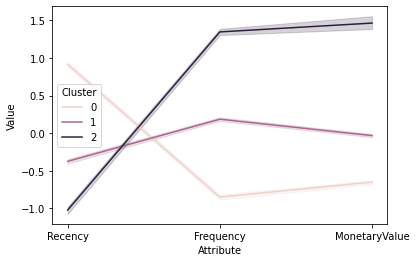

In [41]:
sns.lineplot('Attribute', 'Value', hue='Cluster', data=df_nor_melt)

In [74]:
#Getting unique labels
unique_labels = pd.unique(df_nor_melt['Cluster'])

In [76]:
#array of labels
label = model.labels_ 

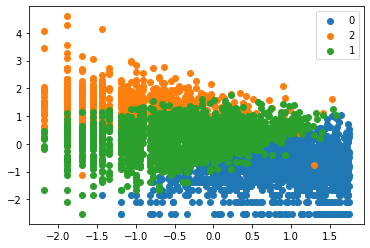

In [77]:
#plotting the results:
for i in unique_labels:
    plt.scatter(customers_normalized[label == i , 0] , customers_normalized[label == i , 1] , label = i)
plt.legend()
plt.show()